In [1]:
%matplotlib inline

import matplotlib
import os
import pandas as pd
import numpy as np

game_names = ['default_game', 'game1', 'game2', 'game3', 'game4', 'game5'] 

c:\programdata\miniconda3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
c:\programdata\miniconda3\lib\site-packages\numpy\.libs\libopenblas.TXA6YQSD3GCQQC22GEQ54J2UDCXDXHWN.gfortran-win_amd64.dll
c:\programdata\miniconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  stacklevel=1)


In [216]:
agent_learning_data = pd.read_csv('./agent learning data/aggregated/game5.csv', header=None)
agent_learning_data[716] = agent_learning_data[716].astype(int)
agent_learning_data.to_csv(game_name + '_v2.csv', header=None, index=False)

# 1. Prepare data 

In [ ]:
# Aggregate data
for game_name in game_names:

    all_agent_learning_data_df = pd.DataFrame()
    filenames = os.listdir('./agent learning data/')
    this_game_files = [filename for filename in filenames if game_name in filename]

    for filename in this_game_files:
        print(filename)
        agent_learning_data_df = pd.read_csv('./agent learning data/' + filename)

        agent_learning_data_df = agent_learning_data_df.drop_duplicates()
        all_agent_learning_data_df = all_agent_learning_data_df.append(agent_learning_data_df)
    agent_learning_data['y'] = agent_learning_data['y'].astype(int)
    agent_learning_data = agent_learning_data[:10000]
    all_agent_learning_data_df.to_csv('./agent learning data/aggregated/' + game_name + '.csv', index=False)

game3__run0.csv
game3__run1.csv
game3__run10.csv
game3__run100.csv
game3__run101.csv
game3__run102.csv
game3__run103.csv
game3__run104.csv
game3__run105.csv
game3__run106.csv
game3__run107.csv
game3__run108.csv
game3__run109.csv
game3__run11.csv
game3__run110.csv
game3__run111.csv
game3__run112.csv
game3__run113.csv
game3__run114.csv
game3__run115.csv
game3__run116.csv
game3__run117.csv
game3__run118.csv
game3__run119.csv
game3__run12.csv
game3__run13.csv
game3__run14.csv
game3__run15.csv
game3__run16.csv
game3__run17.csv
game3__run18.csv
game3__run19.csv
game3__run2.csv
game3__run20.csv
game3__run21.csv
game3__run22.csv
game3__run23.csv
game3__run24.csv
game3__run25.csv
game3__run26.csv
game3__run27.csv
game3__run28.csv
game3__run29.csv
game3__run3.csv
game3__run30.csv
game3__run31.csv
game3__run32.csv
game3__run33.csv
game3__run34.csv
game3__run35.csv
game3__run36.csv
game3__run37.csv
game3__run38.csv
game3__run39.csv
game3__run4.csv
game3__run40.csv
game3__run41.csv
game3__run42.csv

# 2. Neural Network

My computer has a Intel GPU which is not compatible for running tensorflow/keras.
=> the following code was run on the AWS SageMaker Instance:
https://ai-navi-simulated-agents-learning-game-rules.notebook.eu-central-1.sagemaker.aws/notebooks/agent%20learning.ipynb

In [ ]:
from keras.models import Sequential
from keras.layers import Dense

In [ ]:
for game_name in game_names:
    dataset = np.loadtxt(game_name + '_v2.csv', delimiter=',')
    results = []
    for subset_index in range(1,60):
        print('--' + str(subset_index) + '----------')
        dataset_subset = dataset[0:40*subset_index,:]

        nb_of_training_rows = int(len(dataset_subset)*0.8)
        training = dataset[:nb_of_training_rows,0:716]
        X_training = dataset[0:nb_of_training_rows,0:716]
        y_training = dataset[0:nb_of_training_rows,716]
        X_validation = dataset[nb_of_training_rows+1:,0:716]
        y_validation = dataset[nb_of_training_rows+1:,716]

        model = Sequential()
        model.add(Dense(100, input_dim=716, activation='relu'))
        model.add(Dense(50, activation='relu'))
        model.add(Dense(30, activation='relu'))
        model.add(Dense(15, activation='relu'))
        model.add(Dense(8, activation='relu'))
        model.add(Dense(4, activation='relu'))
        model.add(Dense(1, activation='sigmoid'))
        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

        model.fit(X_training, y_training,  epochs=30, batch_size=10)

        _, accuracy = model.evaluate(X_validation, y_validation)
        print('Accuracy: %.2f' % (accuracy*100))
        results.append({'subset_index':subset_index, 
                       'len(dataset_subset)':len(dataset_subset), 
                       'accuracy':accuracy})
        
        
    results_df = pd.DataFrame(results)
    results_df['number of timesteps'] = results_df['subset_index']*2
    results_df.index = results_df['number of timesteps']
    results_df.to_csv('results_' + game_name + '.csv', index=False)



# 3. Analyze

In [6]:
game_name = game_names[5]
results_df = pd.read_csv('./agent learning results/results_' + game_name + '.csv')

results_df['number of observed decisions'] = results_df['number of timesteps']*20
results_df.index = range(len(results_df))

np.max(results_df["accuracy"])

0.5121921896934509

In [ ]:
results_df["accuracy"].plot(ylim=[0.49, 1.003])

### 3.1. remove outliers

In [210]:
for i in np.arange(len(results_df)):
    surrounding_condition = results_df['subset_index'].isin(range(np.max([0,i-8]),(i+1)))
    results_df.loc[i, 'moving average'] = results_df.loc[surrounding_condition,'accuracy'].mean()
    

In [211]:
# moving average curve (reference for outlier detection) 
print('0')
print(len(results_df))
results_df['moving average'] = 0
for i in np.arange(len(results_df)):
    accuracy_col = results_df.columns.get_loc('accuracy')
    moving_average_col = results_df.columns.get_loc('moving average')
    results_df.iloc[i, moving_average_col] = results_df.iloc[np.max([0,i-5]):(i+1),accuracy_col].mean()
    
# find outliers
print('1')
print(len(results_df))
outlier_condition = np.abs(results_df['accuracy'] - results_df['moving average']) > 0.06

# new moving average without outliers
print('2')
print(len(results_df))
results_df.index = range(len(results_df))
for i in np.arange(len(results_df)):
    
    surrounding_condition = results_df['subset_index'].isin(range(np.max([0,i-8]),(i+1)))
    results_df.loc[i, 'moving average'] = results_df.loc[np.logical_and(np.logical_not(outlier_condition), surrounding_condition),'accuracy'].mean()
    print('--' + str(i) + '--------')
    print(list(range(np.max([0,i-8]),(i+1))))
    print(str(results_df.loc[np.logical_and(np.logical_not(outlier_condition), surrounding_condition),'accuracy'].mean()))
          
# print('2')
# print(len(outlier_condition))
# print(len(results_df))
    
# replace outliers
print('3')
print(len(results_df))
not_start_condition =  results_df['number of observed decisions']>300
# results_df.loc[outlier_condition ,'accuracy'] = results_df.loc[outlier_condition, 'moving average']
results_df.loc[np.logical_and(outlier_condition, not_start_condition),'accuracy'] = 1

0
59
1
59
2
59
--0--------
[0]
nan
--1--------
[0, 1]
0.84808349609375
--2--------
[0, 1, 2]
0.847838819026947
--3--------
[0, 1, 2, 3]
0.8476267457008362
--4--------
[0, 1, 2, 3, 4]
0.8465103358030319
--5--------
[0, 1, 2, 3, 4, 5]
0.8449049592018127
--6--------
[0, 1, 2, 3, 4, 5, 6]
0.8414693375428518
--7--------
[0, 1, 2, 3, 4, 5, 6, 7]
0.8398539509092059
--8--------
[0, 1, 2, 3, 4, 5, 6, 7, 8]
0.8387138172984123
--9--------
[1, 2, 3, 4, 5, 6, 7, 8, 9]
0.8380511403083801
--10--------
[2, 3, 4, 5, 6, 7, 8, 9, 10]
0.8365385201242235
--11--------
[3, 4, 5, 6, 7, 8, 9, 10, 11]
0.8356527951028612
--12--------
[4, 5, 6, 7, 8, 9, 10, 11, 12]
0.8308564821879069
--13--------
[5, 6, 7, 8, 9, 10, 11, 12, 13]
0.8279787500699362
--14--------
[6, 7, 8, 9, 10, 11, 12, 13, 14]
0.8258086840311686
--15--------
[7, 8, 9, 10, 11, 12, 13, 14, 15]
0.8241439594162835
--16--------
[8, 9, 10, 11, 12, 13, 14, 15, 16]
0.8228213853306241
--17--------
[9, 10, 11, 12, 13, 14, 15, 16, 17]
0.8223542239930894
--18-

In [212]:
# remake moving average (for smoothing)
for i in np.arange(len(results_df)):
    accuracy_col = results_df.columns.get_loc('accuracy')
    moving_average_col = results_df.columns.get_loc('moving average')
    results_df.iloc[i, moving_average_col] = results_df.iloc[np.max([0,i-5]):(i+1),accuracy_col].mean()

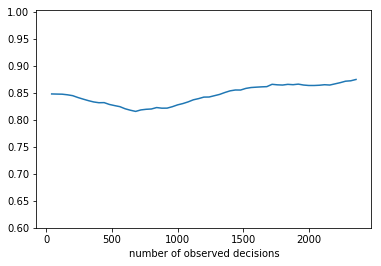

In [213]:
results_df.index = results_df['number of observed decisions']
results_df["moving average"].plot(ylim=[0.6, 1.003])

In [62]:
results_df.columns

Index(['subset_index', 'len(dataset_subset)', 'accuracy',
       'number of timesteps', 'number of observed decisions',
       'moving average'],
      dtype='object')

In [63]:
results_df[['number of observed decisions',"accuracy"]]

,number of observed decisions,accuracy
number of observed decisions,,
40,40,0.560907
80,80,0.611035
120,120,0.722209
160,160,0.780461
200,200,0.821421
240,240,0.850726
280,280,0.923839
320,320,1.000000
360,360,1.000000


In [34]:
results_df['moving average']

number of decisions
40     0
80     0
120    0
160    0
200    0
      ..
439    0
441    0
442    0
443    0
444    0
Name: moving average, Length: 549, dtype: int64